## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет.     


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.inspection import permutation_importance

Прочитаем наш файл с исходными данными:

In [47]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [48]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')	
print(taxi_data['pickup_datetime'].min(), taxi_data['pickup_datetime'].max())

2016-01-01 00:00:17 2016-06-30 23:59:39


### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [49]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [50]:
print(taxi_data['vendor_id'].value_counts())
print(taxi_data['passenger_count'].max())
print(taxi_data['trip_duration'].mean())
print(taxi_data['trip_duration'].median())
print(taxi_data['trip_duration'].min())
print(taxi_data['trip_duration'].max())

vendor_id
2    780302
1    678342
Name: count, dtype: int64
9
959.4922729603659
662.0
1
3526282


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [112]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek
    return df

In [52]:
add_datetime_features(taxi_data) 
display(taxi_data)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,12,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,4
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,6
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,7,4
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,16,1


In [53]:
# Сколько поездок было совершено в субботу?
print(taxi_data[taxi_data['pickup_day_of_week'] == 5].shape[0]) # суббота - 5 начиная с 0

# Сколько поездок в среднем совершается за день? 
group = taxi_data.groupby('pickup_date')['id'].count() # объединим по датам и посчитаем количество любого признака
print(group.mean())

220868
8014.527472527472


### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [54]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
holiday_data['date'] = pd.to_datetime(holiday_data['date'], format='%Y-%m-%d')
holiday_data['date'] = holiday_data['date'].dt.date

In [55]:
def add_holiday_features(arg, data_holiday=holiday_data['date'].tolist()):
# в функцию подается не весь df, а конкретный столбец и автоматически заданная другая таблица
    if arg in data_holiday: return 1
    else: return 0
      

In [56]:
taxi_data['pickup_holiday'] = taxi_data['pickup_date'].apply(add_holiday_features)
taxi_data['pickup_holiday'].value_counts()
taxi_data[taxi_data['pickup_holiday'] == 1]['trip_duration'].median()

585.0

### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

OSRM (Open Source Routing Machine) — это открытый бесплатный ресурс, который активно используется во многих сервисах, предполагающих построение кратчайшего маршрута. Он позволяет построить оптимальный кусочно-линейный путь из точки А в точку B, а также узнать его примерную длительность и длину. У данного сервиса есть API, с которым вы можете познакомиться в документации (https://www.thinkdatascience.com/post/2020-03-03-osrm/osrm/)

Примечание. Время поездки, вычисляемое с помощью OSRM, не является истинным временем поездки, так как оно вычисляется по кратчайшему пути при идеальных условиях: отсутствие пробок, погодных влияний и других внешних факторов. 
Если воспользоваться этим временем поездки как предсказанием, ваша ошибка прогноза будет довольно велика по сравнению с той, которую мы получим при использовании моделей машинного обучения.

In [57]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')
osrm_data

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."
...,...,...,...,...,...,...,...,...,...,...,...,...
1458638,id2976426,Cargo Plaza,East 51st Street,28051.1,1462.5,13,Cargo Plaza|Cargo Plaza|Van Wyck Expressway|Ca...,145.4|1039|12154.4|931.8|6422.3|3745.6|2032.5|...,21|82.8|489.4|57.2|359.5|164.1|139.9|14.4|2.9|...,depart|on ramp|new name|off ramp|merge|fork|ne...,right|slight right|straight|slight right|sligh...,"-73.78445,40.648461|-73.785844,40.647851|-73.7..."
1458639,id1440046,Former Terminal 6 Departures,3rd Avenue,29616.3,1643.2,16,Former Terminal 6 Departures|Cargo Plaza|Cargo...,110.2|415.2|895.1|12154.4|931.8|6422.3|1686.5|...,15.9|63.9|71.6|489.4|57.2|359.5|81.8|19.4|10.3...,depart|fork|on ramp|new name|off ramp|merge|fo...,right|slight left|straight|straight|slight rig...,"-73.779336,40.647005|-73.780349,40.64763|-73.7..."
1458640,id1607338,Cargo Plaza,West 8th Street,25615.0,1765.1,30,Cargo Plaza|Cargo Plaza|Cargo Plaza|Cargo Plaz...,179.5|66.3|314.8|431.8|1557.5|266.3|454.7|604|...,28|9.5|25.2|34.5|62|21.3|36.6|24.1|25.2|238.2|...,depart|fork|on ramp|fork|new name|off ramp|for...,none|slight right|straight|slight left|straigh...,"-73.786697,40.641627|-73.78622,40.643052|-73.7..."
1458641,id2071901,Cargo Plaza,Laurel Hill Boulevard,20284.1,1074.3,14,Cargo Plaza|Cargo Plaza|Cargo Plaza|Van Wyck E...,124.3|535.2|895.1|12154.4|931.8|1521.6|573.1|3...,22|79|71.6|489.4|57.2|85.4|45.9|28.5|22.2|9.5|...,depart|fork|fork|new name|off ramp|merge|off r...,right|straight|slight left|straight|slight rig...,"-73.782317,40.644873|-73.780877,40.645095|-73...."


In [58]:
def add_osrm_features(df, osrm_data=osrm_data):
    # выделяем столбцы из таблицы
    osrm_data = osrm_data[['id', 'total_distance', 'total_travel_time', 'number_of_steps']] # выделяем нужные столбцы
    df_joined = df.join(
        osrm_data.set_index('id'),
        on='id',
        how='left'
        )

    return df_joined


In [59]:
taxi_data = add_osrm_features(taxi_data) 
display(taxi_data)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,12,1,0,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0,1614.9,140.1,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,4,0,2234.6,311.7,8.0
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,6,0,7638.0,589.6,11.0
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,7,4,0,9871.5,642.9,10.0
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,16,1,0,1628.3,161.6,7.0


In [60]:
# 1. Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? Полученную разницу округлите до целого числа.

print(taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median())

# В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб-источника.
# 2. После объединения таблиц, сколько строк содержат пропуски?

taxi_data.info()

372.5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 18 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  object        
 12  pickup_hour         1458644 non-null  int32         
 13  pickup

С помощью географических характеристик можно извлечь ещё немного информации. Если рассматривать Землю как сферу, то, зная широту и долготу начальной и конечной точек маршрута, можно вычислить географическое расстояние между точками на сфере, а также узнать направление движения автомобиля.

Введём в наш анализ расстояние по формуле гаверсинуса. 

Данная формула определяет кратчайшее расстояние между двумя точками на сфере, если известны широта и долгота каждой из точек. Геометрически это длина кратчайшей дуги, связывающей точки на сфере.

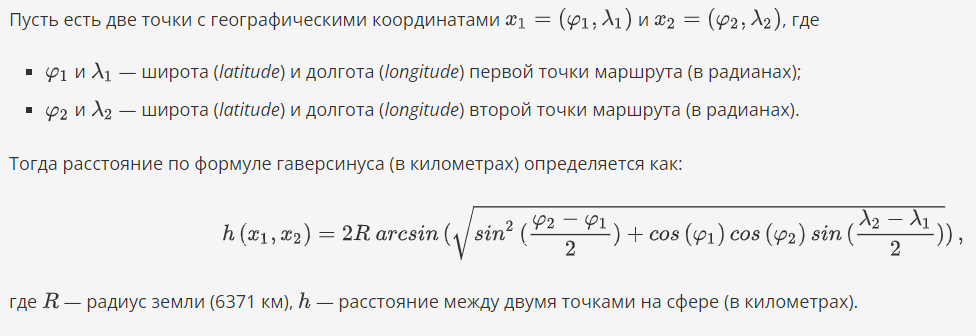

?
В чём разница между расстоянием по формуле гаверсинуса и расстоянием из OSRM? 

Расстояние, вычисляемое в OSRM, — это кратчайший суммарный путь, пройденный по дорожным разметкам.

Взгляните на карту ниже. Если принять Землю за плоскость, то можно показать, что расстояние по формуле гаверсинуса превратится в евклидово расстояние. Тогда величина  будет длиной гипотенузы прямоугольного треугольника (на карте ниже она обозначена зелёным), а вот расстояние из OSRM будет равно сумме длин катетов (на карте обозначено чёрным).

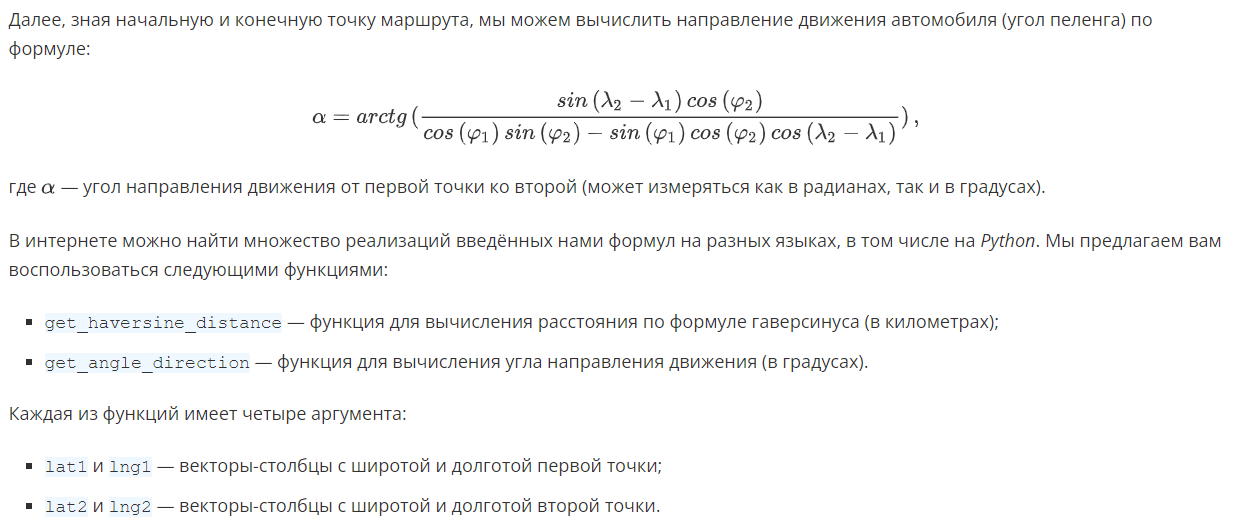

In [61]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [62]:
def add_geographical_features(df):
    # apply с несколькими аргументами
    df['haversine_distance'] = df.apply(lambda x: get_haversine_distance(x['pickup_latitude'], x['pickup_longitude'], x['dropoff_latitude'], x['dropoff_longitude']), axis=1)
    df['direction'] = df.apply(lambda x: get_angle_direction(x['pickup_latitude'], x['pickup_longitude'], x['dropoff_latitude'], x['dropoff_longitude']), axis=1)

    return df

In [63]:
add_geographical_features(taxi_data) 
display(taxi_data)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0,2009.1,164.9,5.0,1.498521,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0,2513.2,332.0,6.0,1.805507,-117.153768
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,12,1,0,11060.8,767.6,16.0,6.385098,-159.680165
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0,1779.4,235.8,4.0,1.485498,-172.737700
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0,1614.9,140.1,5.0,1.188588,179.473585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,2016-04-08,13,4,0,2234.6,311.7,8.0,1.225080,-119.059338
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,2016-01-10,7,6,0,7638.0,589.6,11.0,6.049836,25.342196
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,2016-04-22,7,4,0,9871.5,642.9,10.0,7.824606,-150.788492
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,2016-01-05,16,1,0,1628.3,161.6,7.0,1.092564,35.033294


In [64]:
taxi_data['haversine_distance'].median()

2.0937171329263693

Следующая методика манипуляций с географическими данными — это применение кластеризации по географическим координатам. Идея заключается в том, чтобы сгруппировать все поездки в зависимости от координат начала и конца поездки с помощью методов кластеризации, тем самым добавив информацию о районах, в которых находятся точки старта и конца поездки.

→ Гипотеза состоит в том, что длительность поездки будет зависеть от того, к какому географическому кластеру будет принадлежать поездка.

### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


В качестве метода кластеризации воспользуемся алгоритмом K-Means. Возьмём десять кластеров и обучим его на данных, сформированных из широты и долготы всех точек начала и конца поездок.

In [65]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

C:\Users\Lyudmila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10, random_state=42)

In [66]:
def add_cluster_features(df, kmeans=kmeans):
    df['geo_cluster'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']].values)

    return df

In [67]:
add_cluster_features(taxi_data) 
display(taxi_data)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,direction,geo_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,17,0,0,2009.1,164.9,5.0,1.498521,99.970196,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,0,6,0,2513.2,332.0,6.0,1.805507,-117.153768,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,12,1,0,11060.8,767.6,16.0,6.385098,-159.680165,6
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,19,2,0,1779.4,235.8,4.0,1.485498,-172.737700,6
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,13,5,0,1614.9,140.1,5.0,1.188588,179.473585,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,2016-04-08,13,4,0,2234.6,311.7,8.0,1.225080,-119.059338,1
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,2016-01-10,7,6,0,7638.0,589.6,11.0,6.049836,25.342196,0
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,2016-04-22,7,4,0,9871.5,642.9,10.0,7.824606,-150.788492,6
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,2016-01-05,16,1,0,1628.3,161.6,7.0,1.092564,35.033294,1


In [68]:
taxi_data['geo_cluster'].value_counts()

geo_cluster
1    592117
0    392108
6    340489
8     45518
4     40234
5     32799
7     15355
9        18
3         4
2         2
Name: count, dtype: int64

В наименьшем кластере 2 элемента

### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [69]:
weather_data = pd.read_csv('data/weather_data.csv')

weather_data['date'] = pd.to_datetime(weather_data['date']).dt.date
weather_data['hour'] = pd.to_datetime(weather_data['time']).dt.hour
#weather_data.head()

In [70]:
def add_weather_features(df, weather_data=weather_data):
    weather_data = weather_data[['date', 'hour','temperature', 'visibility', 'wind speed', 'precip', 'events']] # выделяем нужные столбцы
    df_joined = df.merge(weather_data, how='left', left_on=['pickup_date', 'pickup_hour'], right_on = ['date', 'hour']) 

    return df_joined

taxi_data_2 = add_weather_features(taxi_data) 
#display(taxi_data_2)

In [71]:
taxi_data_2 = taxi_data_2.drop(['date', 'hour'], axis = 1)

In [72]:
# 1. Сколько поездок было совершено в снежную погоду?
taxi_data_2['events'].value_counts(dropna=False)

events
NaN     1387167
Rain      58379
Snow      13097
Fog           1
Name: count, dtype: int64

In [73]:
#  Какую долю (в процентах) в общем количестве наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями?
print('Всего пропусков: ', taxi_data_2[taxi_data_2['temperature'].isnull() == True].shape[0])
print('Доля пропусков от общего числа: {:.2f}%'.format(taxi_data_2[taxi_data_2['temperature'].isnull() == True].shape[0]/taxi_data_2.shape[0]*100))
#ДРУГОЙ МЕТОД
#round((taxi_data['visibility'].isnull().mean() * 100), 2)

Всего пропусков:  12083
Доля пропусков от общего числа: 0.83%


### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [74]:
def fill_null_weather_data(df):
    df[['temperature', 'visibility', 'wind speed', 'precip']] = df[['temperature', 'visibility', 'wind speed', 'precip']].fillna(
    df.groupby('pickup_date')[['temperature', 'visibility', 'wind speed', 'precip']].transform('median'))
    # метод трансформ в сочетании с групбай позволяет заполнить пропуски в соответствии с группами
    df['events'] = df['events'].fillna('None')
    
    return df
    
taxi_data_2 = fill_null_weather_data(taxi_data_2) 

In [75]:
taxi_data_2['temperature'].median()

11.1

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


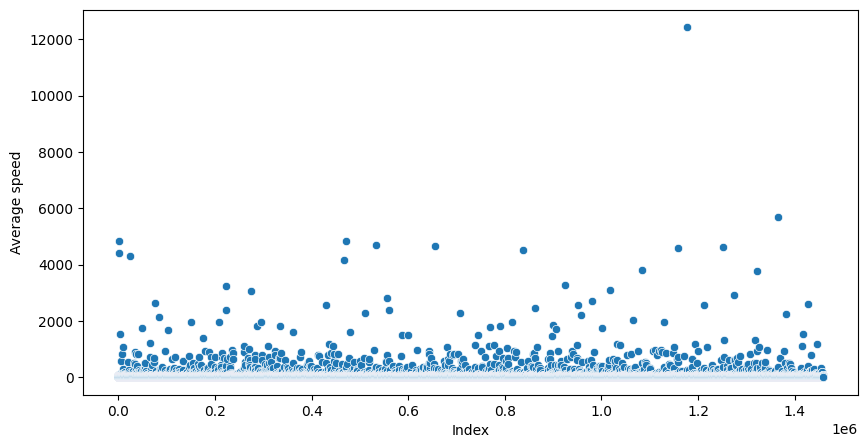

In [76]:
avg_speed = taxi_data_2['total_distance'] / taxi_data_2['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [77]:
outliers = taxi_data_2[taxi_data_2['trip_duration'] > (24*60*60)]
print(outliers.shape[0])
# они являются ошибочными, и от них стоит избавиться
taxi_data_2 = taxi_data_2.drop(outliers.index, axis=0)

outliers_2 = taxi_data_2[(taxi_data_2['total_distance'] / taxi_data_2['trip_duration'] * 3.6) > 300]
print(outliers_2.shape[0])
taxi_data_2 = taxi_data_2.drop(outliers_2.index, axis=0)

4
406


In [78]:
print(f'Результирующее число записей: {taxi_data_2.shape[0]}')

Результирующее число записей: 1458234


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


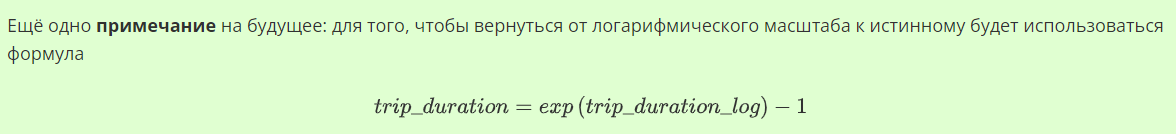

In [79]:
# логарифмированный целевой признак
taxi_data_2['trip_duration_log'] = np.log(taxi_data_2['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

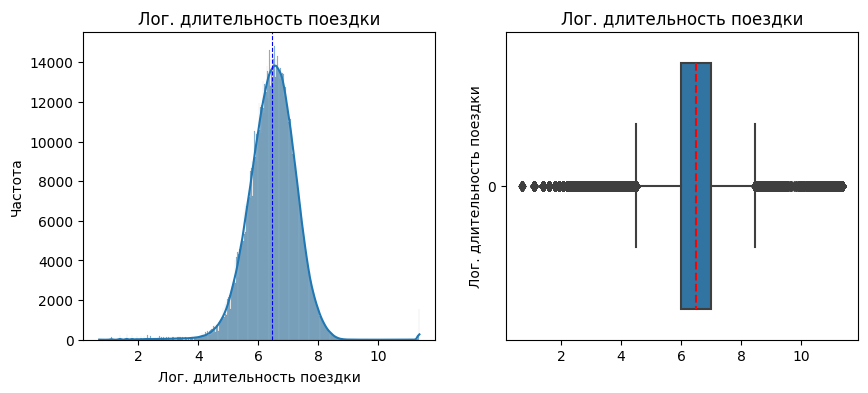

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4)) # 1 и 2 - это количество графиков по осям y и x 

sns.histplot(taxi_data_2['trip_duration_log'], kde=True, ax=axes[0])
axes[0].set(xlabel='Лог. длительность поездки', ylabel='Частота')
axes[0].set_title('Лог. длительность поездки')
axes[0].axvline(taxi_data_2['trip_duration_log'].mean(), color='blue', linestyle='--', linewidth=0.8) # отражает среднее

sns.boxplot(taxi_data_2['trip_duration_log'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'}) # отражает медиану и межквартильный размах
axes[1].set(ylabel='Лог. длительность поездки')
axes[1].set_title('Лог. длительность поездки')

plt.show()

In [81]:
# test Agostino and Peason
res = stats.normaltest(taxi_data_2['trip_duration_log'])
print(res.statistic)
res.pvalue

138354.8629362989


0.0

**p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального**

### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

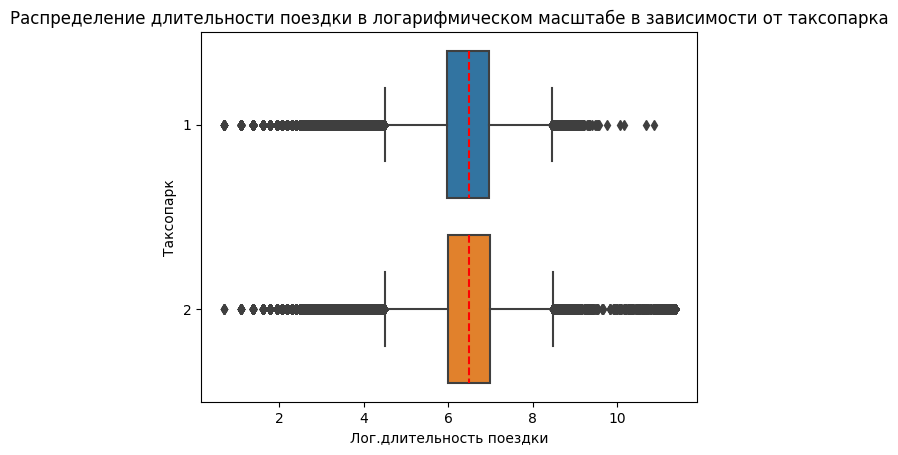

In [82]:
ax = sns.boxplot(taxi_data_2, x='trip_duration_log', y='vendor_id', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Лог.длительность поездки', ylabel='Таксопарк')
plt.title('Распределение длительности поездки в логарифмическом масштабе в зависимости от таксопарка')
plt.show()

**Распределения в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки.**

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

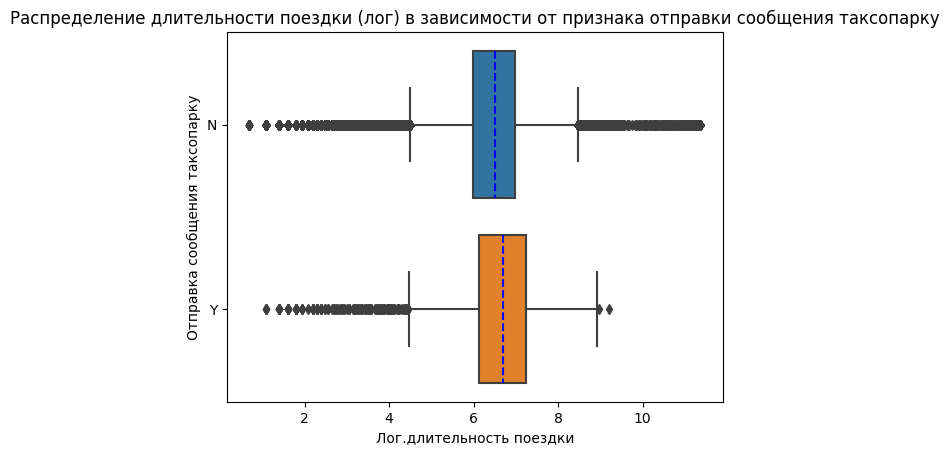

In [83]:
ax = sns.boxplot(taxi_data_2, x='trip_duration_log', y='store_and_fwd_flag', orient='h', medianprops={"color": "blue", "linestyle": '--'})
ax.set(xlabel='Лог.длительность поездки', ylabel='Отправка сообщения таксопарку')
plt.title('Распределение длительности поездки (лог) в зависимости от признака отправки сообщения таксопарку')
plt.show()

**Если внимательно присмотреться к распределению длительности поездок в зависимости от признака store_and_fwd_flag, становится ясно, что наиболее длительные поездки принадлежат к группе N (не хранить и не пересылать поездку). Таким образом, флаг сохраняется только для кратковременных поездок, а для аномальных многочасовых — не сохраняется.**

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

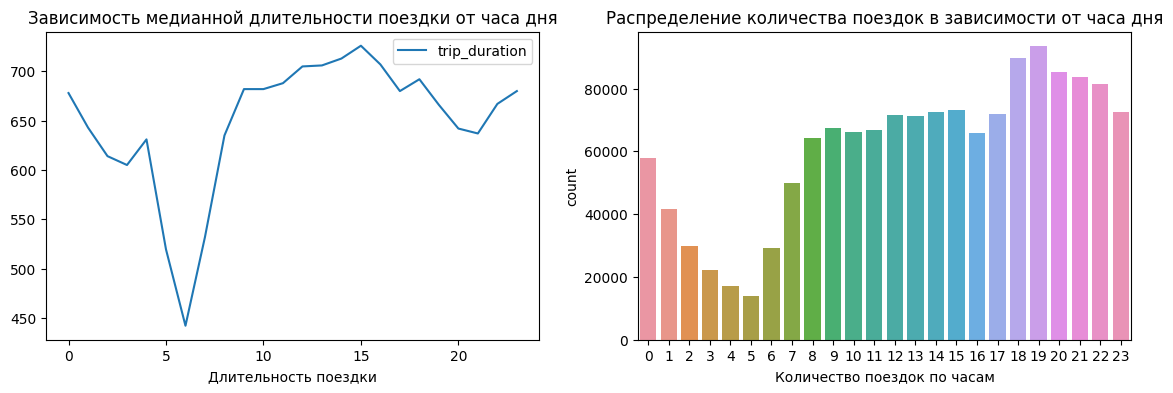

In [84]:
# построим зависимости медианной длительности от часа

median_duration_hour = taxi_data_2.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    aggfunc = 'median',
    #fill_value=0 # заполнение пропусков при агрегации
)

fig, axes = plt.subplots(1, 2, figsize=(14, 4)) # 1 и 2 - это количество графиков по осям y и x 

sns.lineplot(median_duration_hour, ax=axes[0]) 
axes[0].set(xlabel='Длительность поездки')
axes[0].set_title('Зависимость медианной длительности поездки от часа дня')

sns.countplot(taxi_data_2, x='pickup_hour', ax=axes[1]) 
axes[1].set(xlabel='Количество поездок по часам')
axes[1].set_title('Распределение количества поездок в зависимости от часа дня')

plt.show()

**Пик медианной длительности поездки приходится на 15 часа**\
**Больше всего машин заказывают вечером с 18:00, а меньше всего в ночное время**

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


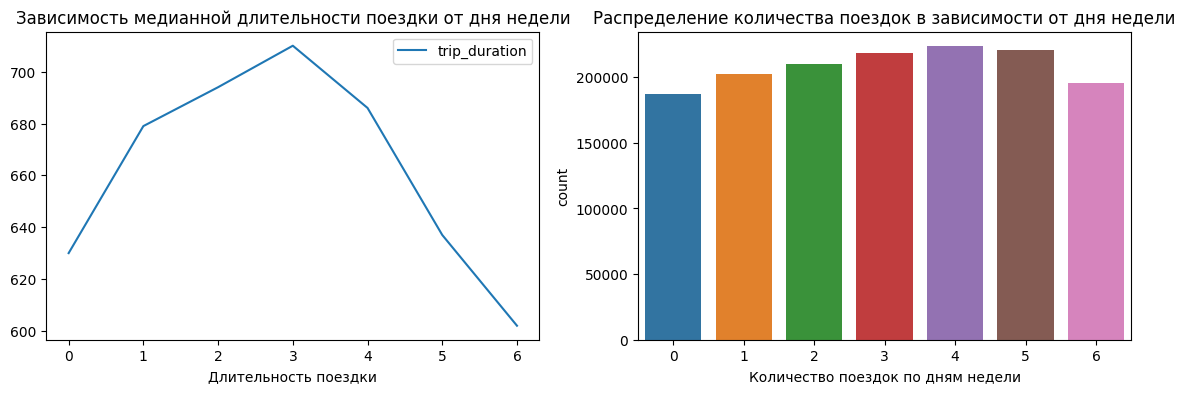

In [85]:
# построим зависимости медианной длительности от дня недели

median_duration_wday = taxi_data_2.pivot_table(
    values='trip_duration',
    index='pickup_day_of_week',
    aggfunc = 'median',
    #fill_value=0 # заполнение пропусков при агрегации
)

fig, axes = plt.subplots(1, 2, figsize=(14, 4)) # 1 и 2 - это количество графиков по осям y и x 

sns.lineplot(median_duration_wday, ax=axes[0]) 
axes[0].set(xlabel='Длительность поездки')
axes[0].set_title('Зависимость медианной длительности поездки от дня недели')

sns.countplot(taxi_data_2, x='pickup_day_of_week', ax=axes[1]) 
axes[1].set(xlabel='Количество поездок по дням недели')
axes[1].set_title('Распределение количества поездок в зависимости от дня недели')

plt.show()

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

In [86]:
median_duration_wday_hour = taxi_data_2.pivot_table(
    values='trip_duration',
    index='pickup_day_of_week',
    columns='pickup_hour',
    aggfunc = 'median',
)

#тепловая карта
fig = px.imshow(
    median_duration_wday_hour,
    aspect='auto', # нормальная размерность
    title='Медианная длительность поездки в зависимости от дня недели и часа поездки'
)
fig.show()

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


In [87]:
mask_plog = (taxi_data_2['pickup_longitude'] >= -74.03) & (taxi_data_2['pickup_longitude'] <= -73.75 )
mask_plat = (taxi_data_2['pickup_latitude'] >= 40.63) & (taxi_data_2['pickup_latitude'] <= 40.85 )
mask_dlog = (taxi_data_2['dropoff_longitude'] >= -74.03) & (taxi_data_2['dropoff_longitude'] <= -73.75 )
mask_dlat = (taxi_data_2['dropoff_latitude'] >= 40.63) & (taxi_data_2['dropoff_latitude'] <= 40.85 )


C:\Users\Lyudmila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



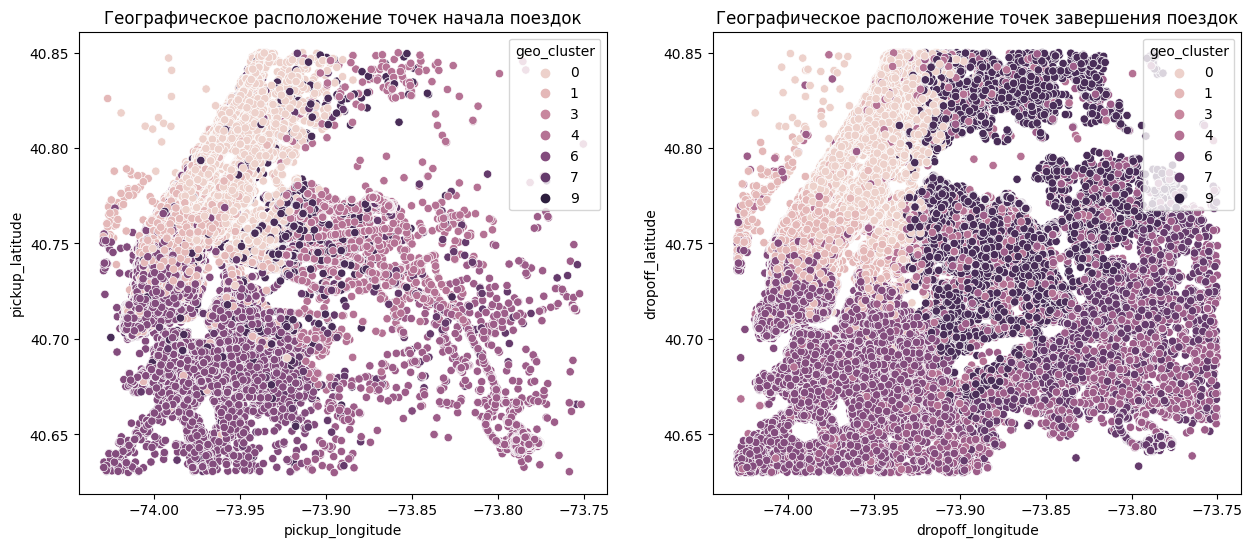

In [88]:
#city_long_border = (-74.03, -73.75)
#city_lat_border = (40.63, 40.85)

fig, axes = plt.subplots(1, 2, figsize=(15, 6)) # 1 и 2 - это количество графиков по осям y и x 

sns.scatterplot(x=taxi_data_2[mask_plog]['pickup_longitude'],
                y=taxi_data_2[mask_plat]['pickup_latitude'],
                hue=taxi_data_2['geo_cluster'],
                ax=axes[0]) 
axes[0].set_title('Географическое расположение точек начала поездок')

sns.scatterplot(x=taxi_data_2[mask_dlog]['dropoff_longitude'],
                y=taxi_data_2[mask_dlat]['dropoff_latitude'],
                hue=taxi_data_2['geo_cluster'], 
                ax=axes[1]) 
axes[1].set_title('Географическое расположение точек завершения поездок')

plt.show()

**В целом мы видим, что 0 и 1  кластеры расположены на северо-западе и перемещаются внутри своего района, аналогичное можно сказать и о 6 кластере на юго-западе. 7 и 9 кластеры подвержены значительным перемещениям - они значительно перемщаются относительно центра и северо-востока. 3 и 4 кластеры распределны менее кучно в районах центра- юго-востока** 

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [89]:
print('Shape of data: {}'.format(taxi_data_2.shape))
print('Columns: {}'.format(taxi_data_2.columns))

Shape of data: (1458234, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [90]:
train_data = taxi_data_2.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,0,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,6,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,6,-5.0,16.1,0.0,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,6,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,0,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [91]:
# a - id
# б - ситуация, в которой данные используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной, но эти данные недоступны в реальных условиях.
# в - dropoff_datetime - она в совокупности с датой и временем начала дает продолжительность, однако дата начала нам нужна

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [92]:
drop_columns = ['id', 'dropoff_datetime', 'pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458234, 23)


### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [93]:
enc = OrdinalEncoder()
enc.fit(train_data[['vendor_id', 'store_and_fwd_flag']]) # обучение
train_data[['vendor_id', 'store_and_fwd_flag']] = enc.transform(train_data[['vendor_id', 'store_and_fwd_flag']]) # замена
#train_data['store_and_fwd_flag'].value_counts() #проверка

In [94]:
print(train_data['vendor_id'].mean())
print(train_data['store_and_fwd_flag'].mean())

0.5349751823095608
0.005514204167506724


Следующие три признака (pickup_day_of_week, geo_cluster, events) являются номинальными.  Для них отлично подойдёт однократное кодирование.

### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [95]:
# Получаем закодированные имена столбцов
train_data_one = pd.get_dummies(train_data, columns=['pickup_day_of_week', 'geo_cluster', 'events'])
train_data_one = train_data_one.dropna(axis=0)

Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [96]:
X = train_data_one.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data_one['trip_duration']
y_log = train_data_one['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [97]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [98]:
selector = SelectKBest(k=25, score_func = f_regression)
selector.fit(X_train, y_train_log)
 
columns = selector.get_feature_names_out()
columns

array(['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'pickup_hour', 'pickup_holiday', 'total_distance',
       'total_travel_time', 'number_of_steps', 'haversine_distance',
       'temperature', 'pickup_day_of_week_0', 'pickup_day_of_week_2',
       'pickup_day_of_week_3', 'pickup_day_of_week_4',
       'pickup_day_of_week_5', 'pickup_day_of_week_6', 'geo_cluster_0',
       'geo_cluster_1', 'geo_cluster_4', 'geo_cluster_5', 'geo_cluster_7',
       'geo_cluster_8'], dtype=object)

Кончилась память, выкраиваем памть путем изменения формата

In [99]:
train_data_one = train_data_one[['vendor_id', 'passenger_count', 'pickup_longitude','pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_hour', 'pickup_holiday', 'total_distance',
       'total_travel_time', 'number_of_steps', 'haversine_distance','temperature', 'pickup_day_of_week_0', 'pickup_day_of_week_2','pickup_day_of_week_3', 'pickup_day_of_week_4',
       'pickup_day_of_week_5', 'pickup_day_of_week_6', 'geo_cluster_0','geo_cluster_1', 'geo_cluster_4', 'geo_cluster_5', 'geo_cluster_7','geo_cluster_8', 'trip_duration', 'trip_duration_log']]

In [100]:
# Select columns with 'float64' dtype  
float64_cols = list(train_data_one.select_dtypes(include='float64'))

# The same code again calling the columns
train_data_one[float64_cols] = train_data_one[float64_cols].astype('float32')

# Select columns with 'float64' dtype  
int64_cols = list(train_data_one.select_dtypes(include='int64'))

# The same code again calling the columns
train_data_one[int64_cols] = train_data_one[int64_cols].astype('int32')

train_data_one['pickup_holiday'] = train_data_one['pickup_holiday'].astype('bool')

### Сохраним измененный датасет с нужными переменными

In [101]:
train_data_one.info()
train_data_one.to_csv('train_data_one.csv', sep=',', index=False) # удалим индексы

<class 'pandas.core.frame.DataFrame'>
Index: 1458233 entries, 0 to 1458643
Data columns (total 27 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   vendor_id             1458233 non-null  float32
 1   passenger_count       1458233 non-null  int32  
 2   pickup_longitude      1458233 non-null  float32
 3   pickup_latitude       1458233 non-null  float32
 4   dropoff_longitude     1458233 non-null  float32
 5   dropoff_latitude      1458233 non-null  float32
 6   pickup_hour           1458233 non-null  int32  
 7   pickup_holiday        1458233 non-null  bool   
 8   total_distance        1458233 non-null  float32
 9   total_travel_time     1458233 non-null  float32
 10  number_of_steps       1458233 non-null  float32
 11  haversine_distance    1458233 non-null  float32
 12  temperature           1458233 non-null  float32
 13  pickup_day_of_week_0  1458233 non-null  bool   
 14  pickup_day_of_week_2  1458233 non-null 

In [102]:
train_data_one = pd.read_csv("train_data_one.csv", sep=',')
train_data_one.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_hour,pickup_holiday,total_distance,total_travel_time,...,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_0,geo_cluster_1,geo_cluster_4,geo_cluster_5,geo_cluster_7,geo_cluster_8,trip_duration,trip_duration_log
0,1.0,1,-73.982155,40.767937,-73.96463,40.765602,17,False,2009.1,164.9,...,False,False,True,False,False,False,False,False,455,6.122493
1,0.0,1,-73.980415,40.738564,-73.99948,40.731150,0,False,2513.2,332.0,...,False,True,False,False,False,False,False,False,663,6.498282
2,1.0,1,-73.979030,40.763940,-74.00533,40.710087,12,False,11060.8,767.6,...,False,False,False,False,False,False,False,False,2124,7.661527
3,1.0,1,-74.010040,40.719970,-74.01227,40.706720,19,False,1779.4,235.8,...,False,False,False,False,False,False,False,False,429,6.063785
4,1.0,1,-73.973050,40.793210,-73.97292,40.782520,13,False,1614.9,140.1,...,True,False,True,False,False,False,False,False,435,6.077642


In [103]:
# Объявляем новый Х
X = train_data_one.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data_one['trip_duration']
y_log = train_data_one['trip_duration_log']

X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


**Помните, что нормализация требуется для предикторов, а не для целевой переменной.**

In [104]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled = np.float32(X_train_scaled)
X_valid_scaled = scaler.transform(X_valid)
X_valid_scaled = np.float32(X_valid_scaled)

In [105]:
# проверяем объем памяти
np.info(X_train_scaled)
print(X_train_scaled.nbytes)

class:  ndarray
shape:  (977016, 25)
strides:  (4, 3908064)
itemsize:  4
aligned:  True
contiguous:  False
fortran:  True
data pointer: 0x246eac00000
byteorder:  little
byteswap:  False
type: float32
97701600


In [106]:
X_valid_scaled[:,0].mean()

0.5354341

ОН СЕЙЧАС В ФОРМАТЕ ARRAY

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [107]:
lr = linear_model.LinearRegression()
lr.fit(X_train_scaled, y_train_log)

#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train_scaled)
y_valid_pred = lr.predict(X_valid_scaled)
#Выводим результирующие метрики
print('RMSLE на тренировочной выборке: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))))
print('RMSLE на валидационной выборке: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))))

RMSLE на тренировочной выборке: 0.531 %
RMSLE на валидационной выборке: 0.534 %


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [109]:
# генерируем полиномиальные признаки
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_valid_scaled_poly = poly.transform(X_valid_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Valid shape: {}'.format(X_valid_scaled_poly.shape))

lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train_log)
y_train_pred = lr_poly.predict(X_train_scaled_poly)
y_valid_pred = lr_poly.predict(X_valid_scaled_poly)

#Выводим результирующие метрики
print('RMSLE на тренировочной выборке: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))))
print('RMSLE на валидационной выборке: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))))

Train shape: (977016, 350)
Valid shape: (481217, 350)
RMSLE на тренировочной выборке: 0.471 %
RMSLE на валидационной выборке: 1.187 %


**Ошибка в валидационной выборке выше, значит модель переобучена**

### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
#Инициализируем объект класса линейная регрессия с L2-регуляризацией 
ridge_lr_poly = linear_model.Ridge()
ridge_lr_poly.fit(X_train_scaled_poly, y_train_log) # ЛОГАРИФМИРОВАНННЫЙ НЕНОРМАЛИЗАВАННЫЙ Y И НОРМАЛИЗОВАННЫЕ Х БЕЗ ЛОГАРИФМА
y_train_pred = ridge_lr_poly.predict(X_train_scaled_poly)
y_valid_pred = ridge_lr_poly.predict(X_valid_scaled_poly)

#Выводим результирующие метрики
print('RMSLE на тренировочной выборке: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))))
print('RMSLE на валидационной выборке: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))))

C:\Users\Lyudmila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning:

Ill-conditioned matrix (rcond=5.35588e-09): result may not be accurate.



RMSLE на тренировочной выборке: 0.472 %
RMSLE на валидационной выборке: 0.477 %


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [ ]:
dt = tree.DecisionTreeRegressor(random_state=42)
dt.fit(X_train_scaled, y_train_log)

y_train_pred = dt.predict(X_train_scaled)
y_valid_pred = dt.predict(X_valid_scaled)

#Выводим результирующие метрики
print('RMSLE на тренировочной выборке: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))))
print('RMSLE на валидационной выборке: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))))

RMSLE на тренировочной выборке: 0.004 %
RMSLE на валидационной выборке: 0.571 %


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [ ]:
param_grid = {'max_depth':[7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
grid_search = GridSearchCV(
    estimator=dt, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error',
    cv=5, #количество фолдов кросс-валидации
    n_jobs = -1 #используем все ядра
) 

%time grid_search.fit(X_train_scaled, y_train_log) 

CPU times: total: 16.3 s
Wall time: -2.5e+12 ns


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                                       18, 19, 20]},
             scoring='neg_mean_squared_error')

In [ ]:
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

Наилучшие значения гиперпараметров: {'max_depth': 11}


In [ ]:
y_train_pred = grid_search.predict(X_train_scaled)
y_valid_pred = grid_search.predict(X_valid_scaled)

#Выводим результирующие метрики
print('RMSLE на тренировочной выборке: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))))
print('RMSLE на валидационной выборке: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))))

RMSLE на тренировочной выборке: 0.415 %
RMSLE на валидационной выборке: 0.431 %


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestRegressor(
    n_estimators=200, # количество моделей
    max_depth=12, # макс глубина
    criterion='squared_error', # критерий информативности
    min_samples_leaf=20, # количество наблюдений в листе
    random_state=42 
)
#Обучаем модель
rf.fit(X_train_scaled, y_train_log)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train_scaled)
y_valid_pred = rf.predict(X_valid_scaled)

#Выводим результирующие метрики
print('RMSLE на тренировочной выборке: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))))
print('RMSLE на валидационной выборке: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))))

RMSLE на тренировочной выборке: 0.404 %
RMSLE на валидационной выборке: 0.414 %


### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [ ]:
gb = GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6, 
    min_samples_split=30,
    random_state=42
)

#Обучаем модель
gb.fit(X_train_scaled, y_train_log)
#Выводим значения метрики 
y_train_pred = gb.predict(X_train_scaled)
y_valid_pred = gb.predict(X_valid_scaled)

#Выводим результирующие метрики
print('RMSLE на тренировочной выборке: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))))
print('RMSLE на валидационной выборке: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))))

RMSLE на тренировочной выборке: 0.373 %
RMSLE на валидационной выборке: 0.395 %


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


In [ ]:
# Сделаем свод
final_modeling = pd.DataFrame({
    'model': ['Linear regression', 'Poly skylearn', 'Poly skylearn+L2', 'DecisionTreeRegressor', 'DecisionTreeRegressor - max_depths 11', 'Random Forest', 'GradientBoostingRegressor'],
    'RMSLE_train_score': [0.54, 0.47, 0.48, 0.0, 0.41, 0.4, 0.37],
    'RMSLE_valid_score': [0.54, 0.7, 0.48, 0.57, 0.43, 0.41, 0.39]
})
display(final_modeling)

,model,RMSLE_train_score,RMSLE_valid_score
0,Linear regression,0.54,0.54
1,Poly skylearn,0.47,0.70
2,Poly skylearn+L2,0.48,0.48
3,DecisionTreeRegressor,0.00,0.57
4,DecisionTreeRegressor - max_depths 11,0.41,0.43
5,Random Forest,0.40,0.41
6,GradientBoostingRegressor,0.37,0.39


### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


1ый вариант

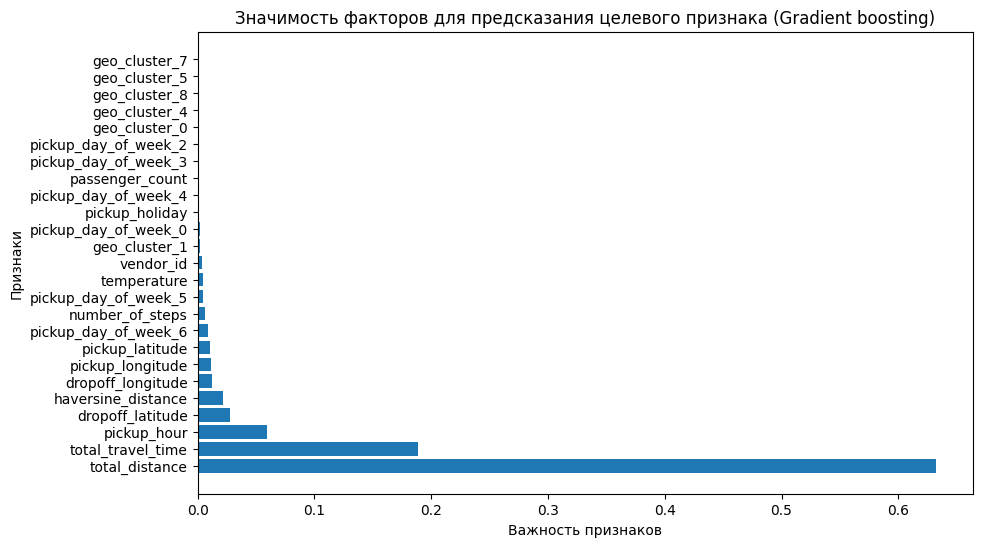

In [ ]:
feature_importances = gb.feature_importances_
# названия признаков
feature_names = X.columns.values

# Создайте DataFrame для важностей и их названий
df_feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
# Сортируйте DataFrame по важностям
df_feature_importance = df_feature_importance.sort_values(by='Importance', ascending=False)

# Стройте столбчатую диаграмму важности признаков
plt.figure(figsize=(10, 6))
plt.barh(df_feature_importance['Feature'], df_feature_importance['Importance'])
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Значимость факторов для предсказания целевого признака (Gradient boosting)')
plt.show()

2ой вариант - сильно дольше из-за второго графика

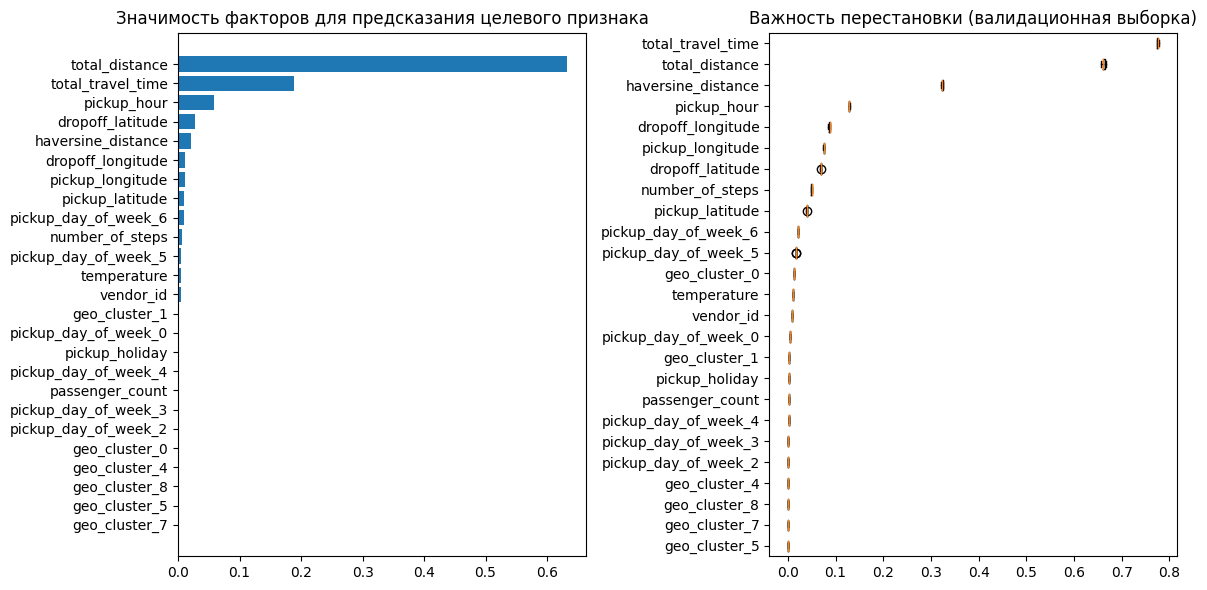

In [ ]:
feature_importance = gb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns.values)[sorted_idx])
plt.title("Значимость факторов для предсказания целевого признака")

result = permutation_importance(
    gb, X_valid_scaled, y_valid_log, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns.values)[sorted_idx],
)
plt.title("Важность перестановки (валидационная выборка)")
fig.tight_layout()
plt.show()

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [ ]:
# обновим y по лучшей модели
y_train_pred = gb.predict(X_train_scaled)
y_valid_pred = gb.predict(X_valid_scaled)

# переведем обратно из логарифмической формы в нормальную
y_train_pred = np.exp(y_train_pred) - 1
y_valid_pred = np.exp(y_valid_pred) - 1
y_train = np.exp(y_train_log) - 1
y_valid = np.exp(y_valid_log) - 1

# Напишем функцию под медианную ошибку
def median_absolute_error(y_true, y_pred):
    errors = np.abs(y_true - y_pred)
    return np.median(errors)

#Выводим результирующие метрики
print('MeAE на тренировочной выборке: {:.3f}'.format((median_absolute_error(y_train, y_train_pred)/60)))
print('MeAE на валидационной выборке: {:.3f}'.format((median_absolute_error(y_valid, y_valid_pred)/60)))

MeAE на тренировочной выборке: 1.818
MeAE на валидационной выборке: 1.844


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [119]:
test_data = pd.read_csv("data/Project5_test_data.csv")
osrm_data_test = pd.read_csv("data/Project5_osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [120]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data['pickup_holiday'] = test_data['pickup_date'].apply(add_holiday_features)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)


In [121]:
test_data = pd.get_dummies(test_data, columns=['pickup_day_of_week', 'geo_cluster', 'events'])
#test_data_onehot = test_data_onehot.dropna(axis=0)

In [127]:
X_test = test_data[columns]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


In [128]:
#Выводим значения метрики 
y_test_pred_log = gb.predict(X_test_scaled)
y_test_pred = np.exp(y_test_pred_log) - 1

#Нет возможности проверить метрику, т.к. y только на кэгл
#print('RMSLE на тестовой выборке: {:.3f} %'.format(np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))))

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [130]:
# ваш код здесь
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_pred})
submission.to_csv('data/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: повышенная производительность путем параллелизации процесса обучения, повышенное качество решения за счет усовершенствования алгоритма бустинга, меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [132]:
#!pip install xgboost

После чего модуль можно импортировать:

In [133]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [138]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=list(columns))
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=list(columns))
dtest = xgb.DMatrix(X_test_scaled, feature_names=list(columns))

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [139]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.73992	valid-rmse:0.74192
[10]	train-rmse:0.49350	valid-rmse:0.49615
[20]	train-rmse:0.44115	valid-rmse:0.44402
[30]	train-rmse:0.42609	valid-rmse:0.42913
[40]	train-rmse:0.41843	valid-rmse:0.42167
[50]	train-rmse:0.41295	valid-rmse:0.41644
[60]	train-rmse:0.40887	valid-rmse:0.41265
[70]	train-rmse:0.40610	valid-rmse:0.41011
[80]	train-rmse:0.40376	valid-rmse:0.40806
[90]	train-rmse:0.40162	valid-rmse:0.40630
[100]	train-rmse:0.39977	valid-rmse:0.40481
[110]	train-rmse:0.39820	valid-rmse:0.40348
[120]	train-rmse:0.39703	valid-rmse:0.40247
[130]	train-rmse:0.39574	valid-rmse:0.40154
[140]	train-rmse:0.39479	valid-rmse:0.40092
[150]	train-rmse:0.39367	valid-rmse:0.40019
[160]	train-rmse:0.39289	valid-rmse:0.39975
[170]	train-rmse:0.39203	valid-rmse:0.39923
[180]	train-rmse:0.39123	valid-rmse:0.39874
[190]	train-rmse:0.39054	valid-rmse:0.39823
[200]	train-rmse:0.38975	valid-rmse:0.39775
[210]	train-rmse:0.38911	valid-rmse:0.39741
[220]	train-rmse:0.38832	valid-rmse:0.39687

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [140]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39468


In [142]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_xgb.csv', index=False)

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

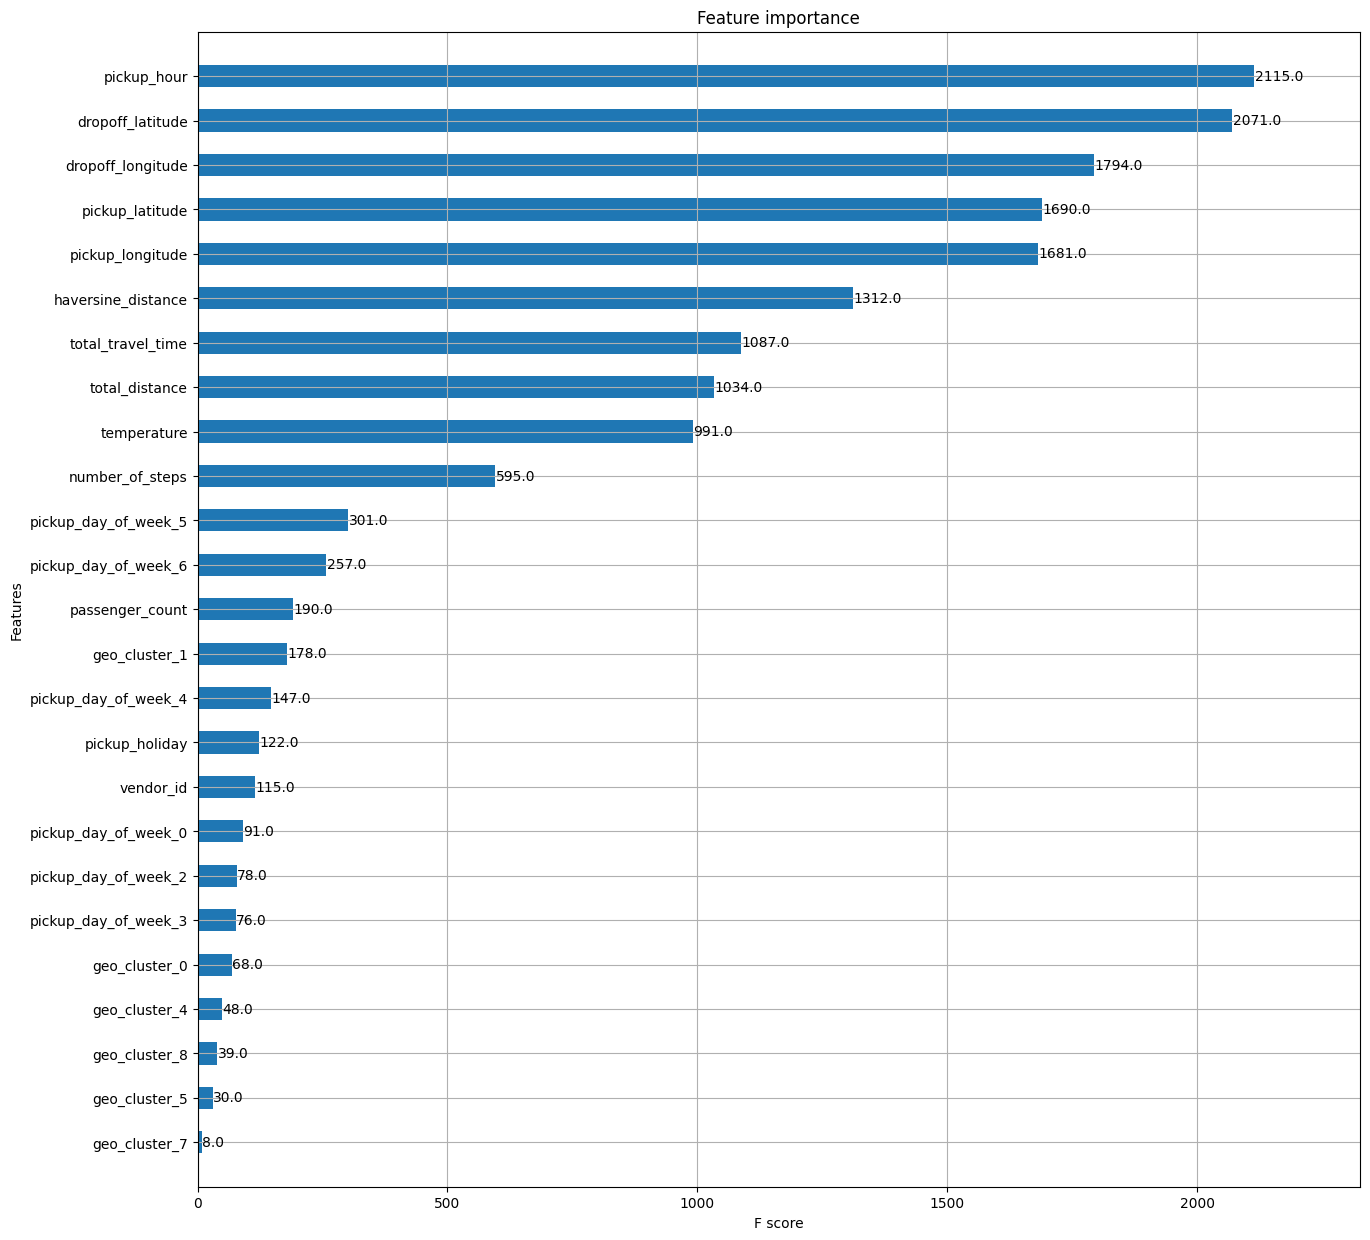

In [141]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)

https://www.kaggle.com/competitions/nyc-taxi-trip-duration/discussion/39553

Крутой ноутбук: https://www.kaggle.com/code/headsortails/nyc-taxi-eda-update-the-fast-the-curious

https://www.kaggle.com/code/au1206/nyc-taxi-duration-prediction-using-xgboost

https://www.kaggle.com/code/jeffreycbw/nyc-taxi-trip-public-0-37399-private-0-37206